In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import correlate, find_peaks
import sounddevice as sd
import wave
# matplotlib qt

# Microphone Parameters
1. Mic Gain: 80
2. Recording Mode: Ambisonics FuMa
3. Recording Format (Sampling Rate): 48kHz
4. Recording Format (Bit depth): 24-bit

In [84]:
# Step 1: Define the parameters

# Reference: Patricio et. al in [14] E. Patricio, A. Ruminski, A. Kuklasinski, 
# L. Januszkiewicz, and T. Zernicki, "Toward Six Degrees of Freedom Audio 
# Recording and Playback Using Multiple Ambisonics Sound Fields," Paper 10141, 
# (2019 March.)

# Number of microphones
M = 3

# Order of Ambisonics
# We are using first order ambisonics in FuMa Format
# Note: WAV Format: W,X,Y,Z
P = 4

# Placing the ambisonic microphones in a triangle, this is the length of the 
# triangle (in centimeters)
triangle_side = 128

# Constants for the attenuation function
volume_threshold = 0.9
volume_range = 0.9
hoa_threshold = 0.9
hoa_range = 1.3

# Defining the indices of the channel
w_channel = 0
x_channel = 1
y_channel = 2
z_channel = 3

# Defining the microphone positions as a global parameter
mic_positions = np.zeros((3, 2))

mic_positions[0, :] = [0, 0]
mic_positions[1, :] = [triangle_side, 0]
mic_positions[2, :] = [triangle_side / 2, (triangle_side * np.sqrt(3)) / 2]

# Functions for wav file processing

In [85]:
from pydub import AudioSegment

def get_num_channels(wav_file_path):
    audio = AudioSegment.from_file(file=wav_file_path, format="wav")  
    num_channels = audio.channels
    return num_channels

# Functions to calculate the attenuation of different microphones. 

In [86]:

def attenuation_and_rebalancing(d_m, t_l=volume_threshold, t_k=hoa_range, s_k_0=1.0, s_k_p_neg=-1.0, s_l_neg=-1.0):
    """
    Distance-dependent attenuation and component re-balancing function.

    Parameters:
    - d_m: distance to the m-th microphone
    - t_l: attenuation threshold
    - t_k: re-balancing threshold
    - s_k_0: slope for the 0th order component
    - s_k_p_neg: slope for higher-order components (p>0)
    - s_l_neg: slope for overall gain

    Returns:
    - Attenuation coefficient for the given distance
    """
    # Equation (3)
    def l(d_m):
        # Piecewise function where: 
        # l(d_m) = 0 if d_m <= t_l
        # l(d_m) = s_l(d_m - t_l) otherwise
        return np.where(d_m <= t_l, 0, s_l(d_m - t_l))

    # Equation (4)
    def k_p(d_m):
        # Piecewise function where: 
        # k_p(d_m) = 0 if d_m <= t_k
        # k_p(d_m) = s_k_p(d_m - t_k) otherwise
        return np.where(d_m <= t_k, 0, s_k_p(d_m - t_k))

    # Component in equation (3)
    def s_l(delta_d):
        # Adjust this function based on the specific behavior of s_l
        # For example, you can use a linear function: return s_l_neg * delta_d
        return s_l_neg * delta_d

    # Component in equation (4)
    def s_k_p(delta_d):
        # Adjust this function based on the specific behavior of s_k_p
        # For p=0, the slope is positive; for p>0, the slope is negative
        return np.where(delta_d <= 0, s_k_0, s_k_p_neg * delta_d)

    # Equation (2)
    return 10 ** ((l(d_m) + k_p(d_m)) / 20.0)

# Function to compute the distance between the interpolation points and the microphone
def compute_distance(interp_point, mic_number, triangle_side):
    
    # Euclidean distance between the interpolation point and the microphone

    distance = np.linalg.norm(interp_point - mic_positions[mic_number, :])
    return distance

# Function to extract the w, x, y, z channel signals
def extract_channels(mic_signal):
    # W Channel (Omni directional)
    w_signal = mic_signal[:, w_channel].astype(float)
    # X Channel
    x_signal = mic_signal[:, x_channel].astype(float)
    # Y Channel
    y_signal = mic_signal[:, w_channel].astype(float)
    # Z Channel
    z_signal = mic_signal[:, w_channel].astype(float)

    return w_signal, x_signal, y_signal, z_signal

# Getting the minimum length of the signals
def get_min_length(mic1_signal, mic2_signal, mic3_signal):
    return min(len(mic1_signal), len(mic2_signal), len(mic3_signal))



# Finding the time lag among the three different microphone recordings

In [87]:
import numpy as np
import scipy.signal
from scipy.io import wavfile

fs, mic1_signal = wavfile.read('../data/02_14/mic1.WAV')
_, mic2_signal = wavfile.read('../data/02_14/mic2.WAV')
_, mic3_signal = wavfile.read('../data/02_14/mic3.WAV')

# Extracting the data from each channel
mic1_w_signal, mic1_x_signal, mic1_y_signal, mic1_z_signal = extract_channels(mic1_signal)
mic2_w_signal, mic2_x_signal, mic2_y_signal, mic2_z_signal = extract_channels(mic2_signal)
mic3_w_signal, mic3_x_signal, mic3_y_signal, mic3_z_signal = extract_channels(mic3_signal)

# Making the microphone signals all the same length as the lowest one
min_w_length = get_min_length(mic1_w_signal, mic2_w_signal, mic3_w_signal)
min_x_length = get_min_length(mic1_x_signal, mic2_x_signal, mic3_x_signal)
min_y_length = get_min_length(mic1_y_signal, mic2_y_signal, mic3_y_signal)
min_z_length = get_min_length(mic1_z_signal, mic2_z_signal, mic3_z_signal)
assert(min_w_length == min_x_length == min_y_length == min_z_length)

start = 500000 # Find some way to change this, it's a bit arbitrary now. 
min_length = min_w_length # Once we confirmed that the channel lengths are the same

# Making all the signals the minimum length
# Mic 1
mic1_w_signal = mic1_w_signal[start:min_length]
mic1_x_signal = mic1_x_signal[start:min_length]
mic1_y_signal = mic1_y_signal[start:min_length]
mic1_z_signal = mic1_z_signal[start:min_length]

# Mic 2
mic2_w_signal = mic2_w_signal[start:min_length]
mic2_x_signal = mic2_x_signal[start:min_length]
mic2_y_signal = mic2_y_signal[start:min_length]
mic2_z_signal = mic2_z_signal[start:min_length]

# Mic 3
mic3_w_signal = mic3_w_signal[start:min_length]
mic3_x_signal = mic3_x_signal[start:min_length]
mic3_y_signal = mic3_y_signal[start:min_length]
mic3_z_signal = mic3_z_signal[start:min_length]

# Re-organizing them in terms of their directional components
w_matrix = np.array([mic1_w_signal, mic2_w_signal, mic3_w_signal])
x_matrix = np.array([mic1_x_signal, mic2_x_signal, mic3_x_signal])
y_matrix = np.array([mic1_y_signal, mic2_y_signal, mic3_y_signal])
z_matrix = np.array([mic1_z_signal, mic2_z_signal, mic3_z_signal])

# Regenerating the wav files from the signals
# Perform the Fourier transform of the omnidirectional signals
f_mic1 = np.fft.fft(mic1_w_signal)
f_mic2 = np.fft.fft(mic2_w_signal)
f_mic3 = np.fft.fft(mic3_w_signal)

# # Calculate cross-correlation in the frequency domain
# # np.conj: Finds the complex conjugate of the fourier transform

correlation12 = np.fft.ifft(f_mic1 * np.conj(f_mic2))
correlation13 = np.fft.ifft(f_mic1 * np.conj(f_mic3))
correlation23 = np.fft.ifft(f_mic2 * np.conj(f_mic3))

print(f'Correlation12: {correlation12}')
print(f'Correlation13: {correlation13}')
print(f'Correlation23: {correlation23}')

# Find the lag with maximum correlation
lag12 = np.argmax(np.abs(correlation12))
lag13 = np.argmax(np.abs(correlation13))
lag23 = np.argmax(np.abs(correlation23))

# Calculate time delays
delay12 = lag12 / fs
delay13 = lag13 / fs
delay23 = lag23 / fs

print(f'Time delay between mic1 and mic2: {delay12:.5f} seconds')
print(f'Time delay between mic1 and mic3: {delay13:.5f} seconds')
print(f'Time delay between mic2 and mic3: {delay23:.5f} seconds')

lag = np.array([lag13, lag23, 0])

/var/folders/z7/38nrk_xn0gg2mnhxz1rbjtt00000gn/T/ipykernel_41966/1791422043.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, mic1_signal = wavfile.read('../data/02_14/mic1.WAV')
/var/folders/z7/38nrk_xn0gg2mnhxz1rbjtt00000gn/T/ipykernel_41966/1791422043.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, mic2_signal = wavfile.read('../data/02_14/mic2.WAV')
/var/folders/z7/38nrk_xn0gg2mnhxz1rbjtt00000gn/T/ipykernel_41966/1791422043.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, mic3_signal = wavfile.read('../data/02_14/mic3.WAV')


Correlation12: [-1.14272380e+18+184.40350237j -1.13446719e+18-148.04268678j
 -1.12552643e+18+119.76907451j ... -1.16524966e+18-473.69271351j
 -1.15801704e+18-196.13732071j -1.15071125e+18-414.18482227j]
Correlation13: [-2.14657298e+18-174.18451473j -2.21620765e+18-425.63638552j
 -2.28194415e+18-496.89105181j ... -1.92431041e+18-696.38117843j
 -2.00038743e+18-510.95758983j -2.07439590e+18-463.30625341j]
Correlation23: [-7.36816641e+18 -238.30217916j -7.09638845e+18 -739.04417654j
 -6.81983401e+18-1872.43279386j ... -8.15102654e+18-1242.7306727j
 -7.89569552e+18 -451.19771004j -7.63456066e+18-1557.63332983j]
Time delay between mic1 and mic2: 4.60152 seconds
Time delay between mic1 and mic3: 9.29875 seconds
Time delay between mic2 and mic3: 4.70890 seconds


In [88]:
# Function to plot four different waves
def plot_waves(time_axis, signal, title, xlabel='Time', ylabel='Amplitude'):
    # Extracting the channels
    w, x, y, z = extract_channels(signal)

    # Plotting the W componment
    plt.subplot(2, 2, 1)
    plt.plot(time_axis, w, color='blue')
    plt.title(f'{title} W component')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Plotting the X component
    plt.subplot(2, 2, 2)
    plt.plot(time_axis, x, color='green')
    plt.title(f'{title} X component')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Plotting the Y component
    plt.subplot(2, 2, 3)
    plt.plot(time_axis, y, color='red')
    plt.title(f'{title} Y component')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Plotting the Z component
    plt.subplot(2, 2, 4)
    plt.plot(time_axis, z, color='orange')
    plt.title(f'{title} Z component')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.tight_layout()
    plt.show()



In [89]:
# Step 2: Load your ambisonic signals y_m_p(n) from WAV files
path_to_files = '../data/02_14/'
file_names = ['mic1.wav', 'mic2.wav', 'mic3.wav']  # Adjust with your file names

# Initialize an array to store ambisonic signals
min_samples = min([wavfile.read(path_to_files + file_name)[1].shape[0] for file_name in file_names])
print(f'Max Samples: {min_samples}')
y_m_p = np.zeros((M, P, min_samples))  # Initialize with the maximum number of samples

# This takes the y_m_p values
# y_m_p format: [mic_1(w,x,y,z), mic_2(w,x,y,z), mic3(w,x,y,z)]
for m in range(M):
    # Read the WAV file
    fs, y = wavfile.read(path_to_files + file_names[m])
    
    y = y[lag[m]: , :]
    
    # Take the 4 channels 
    y_m_p[m, :, :y.shape[0]] = y[:, :P].T

# Reshaping the array to sort them by 
y_m_p_tmp = []
for p in range(P):
    temp_arr = []
    # Taking the individual components of the arrays
    for item in y_m_p:
        temp_arr.append(item[p])
    y_m_p_tmp.append(temp_arr)
y_m_p = np.array(y_m_p_tmp)
N = y_m_p.shape[2]
print(y_m_p.shape)

/var/folders/z7/38nrk_xn0gg2mnhxz1rbjtt00000gn/T/ipykernel_41966/2212851694.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  min_samples = min([wavfile.read(path_to_files + file_name)[1].shape[0] for file_name in file_names])


Max Samples: 2518272


/var/folders/z7/38nrk_xn0gg2mnhxz1rbjtt00000gn/T/ipykernel_41966/2212851694.py:14: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, y = wavfile.read(path_to_files + file_names[m])


(4, 3, 2518272)


X_P shape: (2418272, 4)


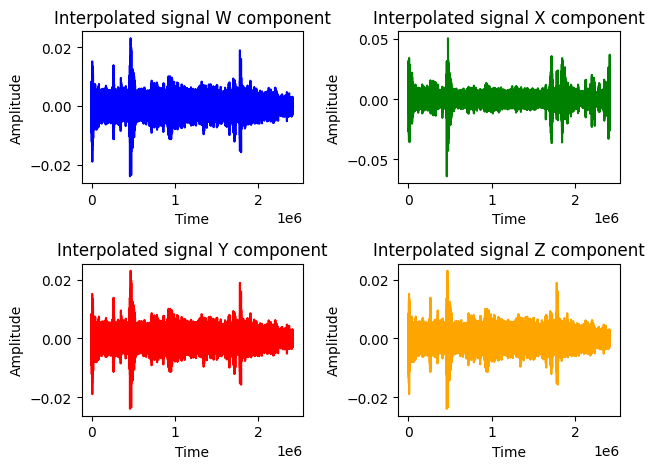

/var/folders/z7/38nrk_xn0gg2mnhxz1rbjtt00000gn/T/ipykernel_41966/4036282981.py:42: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, gt_signal = wavfile.read('../data/02_14/gt.WAV')


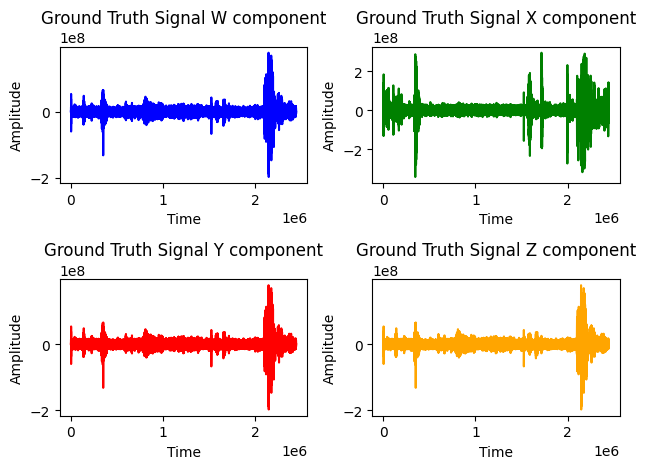

In [90]:
# Interpolation point coordinates

# Centroid
interp_point = np.array([triangle_side / 2, (triangle_side * np.sqrt(3)) / 6])  # centroid

# Bottom axis
# interp_point = np.array([triangle_side / 4, 2])  # Bottom point

# Compute the distance for all samples at once (This is the d_m function)
distances = np.array([compute_distance(interp_point, m, triangle_side) for m in range(M)])

# Compute the attenuation coefficients for each microphone using broadcasting (This calculates the a_p(d_m))
a_p_values = attenuation_and_rebalancing(distances[:, np.newaxis])

# Getting the W,X,Y,Z components for x_p
x_p = []
x_p_start = 100000
# Looping through the values to get each row of x_p
for p in range(P):
    # Isolating either the w, x, y, or z components
    y_m_p_indiv = y_m_p[p]
    x_p_indiv = np.sum(a_p_values[:, :, np.newaxis] * y_m_p_indiv, axis=(0, 1))
    x_p.append(x_p_indiv[x_p_start:])
    # x_p.append(x_p_indiv)


x_p = np.array(x_p)
x_p = x_p.T
print(f'X_P shape: {x_p.shape}')

x_p = x_p/1000.0

# Plot
time_axis = np.arange(1, x_p.shape[0] + 1)
wavfile.write('output_centroid.wav', fs, x_p)

# Plotting the interpolated signal

plot_waves(time_axis, x_p, 'Interpolated signal')

# # Plotting the ground truth signal
_, gt_signal = wavfile.read('../data/02_14/gt.WAV')
gt_time = np.arange(1, gt_signal.shape[0] + 1)
plot_waves(gt_time, gt_signal, 'Ground Truth Signal')


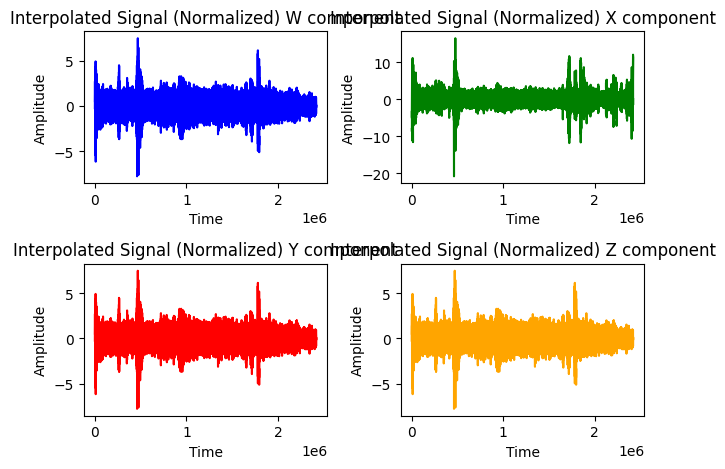

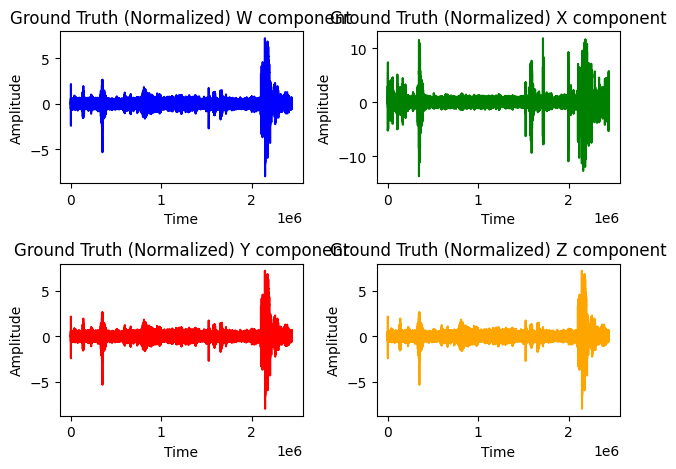

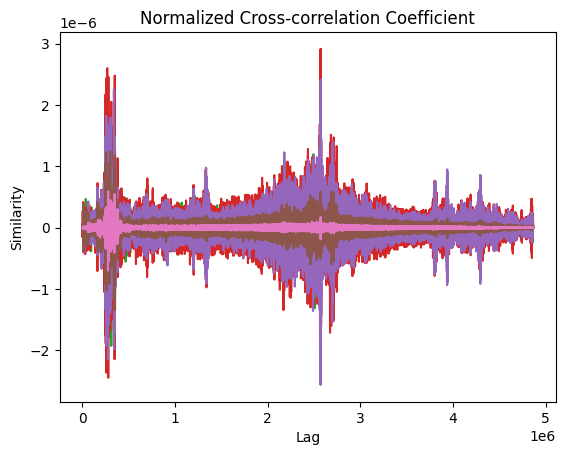

In [91]:
# Performing cross correlation
from scipy.signal import correlate

# First, we want to normalize it on the same amplitude scale
x_p_normalized = (x_p - np.mean(x_p)) / np.std(x_p)
gt_signal_normalized = (gt_signal - np.mean(gt_signal)) / np.std(gt_signal)

# Plot the normalized graphs
plot_waves(time_axis, x_p_normalized, 'Interpolated Signal (Normalized)')

plot_waves(gt_time, gt_signal_normalized, 'Ground Truth (Normalized)')

# Calculate cross-correlation
correlation_result = correlate(x_p_normalized, gt_signal_normalized, mode='full')

# Calculate normalized cross-correlation coefficient
norm_cross_corr_coeff = correlation_result / (len(x_p) * np.std(x_p) * np.std(gt_signal))

# Plot the similarity graph
plt.plot(norm_cross_corr_coeff)
plt.title('Normalized Cross-correlation Coefficient')
plt.xlabel('Lag')
plt.ylabel('Similarity')
plt.show()

# Verification of maximum correlation
Note: This is hardcoded

In [99]:
# 1. Array of points of y-values
points = np.arange(30, 81, 1)
num_points = len(points)
signals = []

# Array of cross correlation values
cross_corr_values = []

# Getting the values of cross_correlations
for i in range(num_points):
    y_point = points[i]
    interp_point = np.array([triangle_side / 2, y_point])
    distances = np.array([compute_distance(interp_point, m, triangle_side) for m in range(M)])
    a_p_values = attenuation_and_rebalancing(distances[:, np.newaxis])
    # Getting the W,X,Y,Z components for x_p
    x_p = []
    x_p_start = 100000
    # Looping through the values to get each row of x_p
    for p in range(P):
        # Isolating either the w, x, y, or z components
        y_m_p_indiv = y_m_p[p]
        x_p_indiv = np.sum(a_p_values[:, :, np.newaxis] * y_m_p_indiv, axis=(0, 1))
        x_p.append(x_p_indiv[x_p_start:])

    x_p = np.array(x_p)
    x_p = x_p.T
    x_p = x_p/1000.0

    # Normalizing x_p
    x_p_normalized = (x_p - np.mean(x_p)) / np.std(x_p)
    signals.append(x_p_normalized)

# Cross correlating the signals
for signal in signals:
    cross_corr = correlate(gt_signal_normalized, signal, mode='full')
    cross_corr_values.append(cross_corr)

# Identifying time shifts
time_shifts = [np.argmax(cross_corr) - (len(gt_signal_normalized) - 1) for cross_corr in cross_corr_values]

# Quantifying similarities
max_corr_values = [np.max(cross_corr) for cross_corr in cross_corr_values]
print(f"Max correlation values: {max_corr_values}")

most_similar_index = np.argmax(max_corr_values)
most_similar_signal = signals[most_similar_index]

# We expect it to say 55
print(f"The most signal is the one with y value: {points[most_similar_index]}")



Max correlation values: [539788.5913646444, 539788.5913646444, 539788.591364644, 539788.5913646444, 539788.5913646444, 539788.5913646441, 539788.5913646442, 539788.5913646445, 539788.591364644, 539788.5913646439, 539788.5913646438, 539788.5913646442, 539788.5913646442, 539788.5913646442, 539788.591364644, 539788.591364644, 539788.5913646442, 539788.5913646444, 539788.5913646438, 539788.5913646444, 539788.591364644, 539788.5913646445, 539788.5913646441, 539788.5913646448, 539788.5913646442, 539788.5913646446, 539788.5913646442, 539788.5913646447, 539788.5913646442, 539788.5913646439, 539788.5913646442, 539788.5913646444, 539788.5913646438, 539788.5913646442, 539788.591364644, 539788.591364644, 539788.5913646438, 539788.5913646442, 539788.5913646442, 539788.5913646442, 539788.5913646442, 539788.5913646444, 539788.5913646442, 539788.5913646445, 539788.5913646441, 539788.5913646438, 539788.5913646444, 539788.5913646446, 539788.5913646439, 539788.5913646442, 539788.5913646445]
The most sign

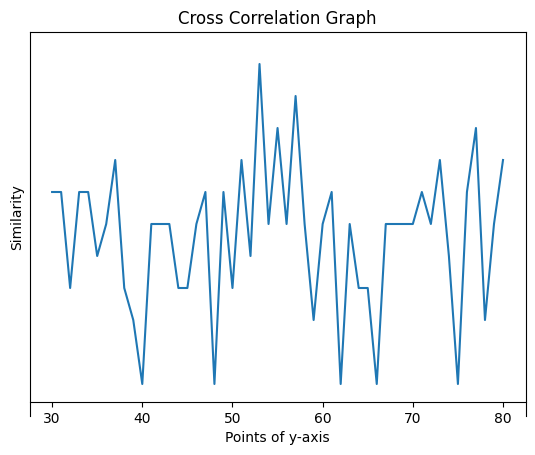

In [108]:
# Normalize the max_corr_values:


# Plotting the graph
plt.plot(points, max_corr_values)
lower_bound = np.min(max_corr_values) - 0.0000000001
upper_bound = np.max(max_corr_values) + 0.0000000001
plt.ylim(lower_bound, upper_bound)
plt.title("Cross Correlation Graph")
plt.xlabel("Points of y-axis")
plt.ylabel("Similarity")
plt.show()
